# **Predicting emissions using the _XARIMA_ model**

In [127]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pmdarima.arima import auto_arima

In [105]:
# Read preprocessed data
data = pd.read_csv('data_final.csv', index_col='Unnamed: 0', parse_dates=['date_etablissement_dpe'])

# Split data according to category
data_admin = data[data.sect_act_admin == 1.0].reset_index(drop=True).iloc[:, :-4]
data_centre_com = data[data.sect_act_centre_com == 1.0].reset_index(drop=True).iloc[:, :-4]
data_occup_cont = data[data.sect_act_occup_cont == 1.0].reset_index(drop=True).iloc[:, :-4]
data_autre = data[data.sect_act_autre == 1.0].reset_index(drop=True).iloc[:, :-4]

In [106]:
data_admin

,date_etablissement_dpe,annee_construction,surface_utile,code_postal,emission_ges,coord_x,coord_y,num_departement
0,2013-04-14,1983.000000,5.3,56700.0,18.228571,235232.573267,6.760084e+06,56.0
1,2013-04-02,2001.000000,100.0,69100.0,11.530000,846390.890452,6.520861e+06,69.0
2,2013-04-16,1985.857143,533.0,83500.0,13.000000,933977.928777,6.227476e+06,83.0
3,2013-04-13,1938.571429,2202.0,83170.0,19.000000,947904.248160,6.261214e+06,83.0
4,2013-04-17,1947.000000,100.0,83600.0,9.428571,447610.588332,6.689189e+06,83.0
...,...,...,...,...,...,...,...,...
185784,2023-10-02,1934.000000,100.0,75009.0,10.842857,651622.970000,6.864097e+06,75.0
185785,2023-05-11,1947.000000,100.0,13001.0,9.285714,893193.240000,6.247145e+06,13.0
185786,2022-04-14,1949.000000,153.0,77260.0,22.714286,709436.300000,6.872237e+06,77.0
185787,2024-08-01,1947.000000,100.0,77310.0,16.857143,664312.900000,6.826206e+06,77.0


Let's take a look at the unique dates to have an idea of the size of our time series.

In [107]:
print(f'Size = {data_admin.date_etablissement_dpe.unique().shape[0]}')

Size = 4252


**Aggregating columns with respect to the date column**

In [108]:
def extract_vect_ts(df):
    df_1, df_2 = df[['date_etablissement_dpe', 'emission_ges', 'surface_utile']], df.drop(columns='emission_ges')

    def weighted_avg(sub_df):
            return (sub_df.surface_utile*sub_df.emission_ges).sum()/sub_df.surface_utile.sum()
        
    ts_1 = df_1.groupby('date_etablissement_dpe').apply(weighted_avg, include_groups=False).sort_index()

    ts_2 = df_2.groupby(by='date_etablissement_dpe').agg({
        'annee_construction': 'mean', 
        'surface_utile': 'mean', 
        'code_postal': 'median', 
        'coord_x': 'mean', 
        'coord_y': 'mean', 
        'num_departement': 'median'
    }).sort_index()

    ts = pd.concat([ts_2, ts_1], axis=1).rename(columns={0: 'emission_ges'})['2013':'2024']
    
    ts = ts.resample('D').interpolate(method='linear')
    
    return ts


In [109]:
ts_admin = extract_vect_ts(data_admin)
ts_admin

,annee_construction,surface_utile,code_postal,coord_x,coord_y,num_departement,emission_ges
date_etablissement_dpe,,,,,,,
2013-01-09,1974.000000,100.000000,93110.000000,661276.385727,6.863710e+06,93.000000,27.130000
2013-01-10,1974.000000,100.000000,92093.272727,658491.653513,6.860496e+06,91.981818,27.186000
2013-01-11,1974.000000,100.000000,91076.545455,655706.921298,6.857281e+06,90.963636,27.242000
2013-01-12,1974.000000,100.000000,90059.818182,652922.189084,6.854066e+06,89.945455,27.298000
2013-01-13,1974.000000,100.000000,89043.090909,650137.456869,6.850851e+06,88.927273,27.354000
...,...,...,...,...,...,...,...
2024-12-27,1966.103896,95.272727,59370.000000,605967.409091,6.796491e+06,59.000000,10.712296
2024-12-28,1968.702381,127.375000,34855.000000,557274.550000,6.598184e+06,34.500000,6.966531
2024-12-29,1960.873840,167.015584,54000.000000,620399.459351,6.712020e+06,54.000000,13.601574


_Remark:_ For the resampling step, only 156 rows out of our 4375 rows were interpolated, the remaining rows were already present in the dataset.

**Prediction and validation**

Before predicting let's define a function that splits our data into a train time series and test time series.

In [110]:
def split(ts):
    ts_train, ts_test = train_test_split(ts, test_size = 0.01, shuffle=False)
    return ts_train, ts_test

Now let's apply our model to predict ts_admin values.

In [111]:
ts_admin_train, ts_admin_test = split(ts_admin)

In [112]:
ts_admin_train.tail()

,annee_construction,surface_utile,code_postal,coord_x,coord_y,num_departement,emission_ges
date_etablissement_dpe,,,,,,,
2024-11-13,1964.322014,125.065574,47375.0,640157.096988,6.653952e+06,50.0,12.028250
2024-11-14,1963.905248,279.811224,56782.5,656965.954388,6.628539e+06,56.5,8.176576
2024-11-15,1954.375000,100.000000,77550.0,677195.928750,6.631538e+06,77.5,11.414107
2024-11-16,1955.671429,197.240000,49255.0,648167.607000,6.619393e+06,49.0,15.225470
2024-11-17,1967.756816,709.145802,59290.0,657031.015859,6.636406e+06,59.0,11.116728


In [113]:
ts_admin_test.head()

,annee_construction,surface_utile,code_postal,coord_x,coord_y,num_departement,emission_ges
date_etablissement_dpe,,,,,,,
2024-11-18,1962.065574,156.082787,60695.0,654817.488115,6.639123e+06,59.0,8.814824
2024-11-19,1967.555071,268.922137,47160.0,639976.447998,6.658419e+06,47.0,15.819041
2024-11-20,1965.793535,344.057664,66000.0,633093.780721,6.665179e+06,66.0,10.593910
2024-11-21,1967.964286,189.708621,56350.0,645784.464655,6.655714e+06,56.0,11.236928
2024-11-22,1959.329670,379.926923,59655.5,632836.521538,6.674348e+06,59.5,17.700764


In [114]:
model = ARIMA(endog=ts_admin_train.emission_ges, exog=ts_admin_train.drop(columns='emission_ges'), order=(0, 1, 2))
model_fit = model.fit()
ges_pred = model_fit.forecast(steps=len(ts_admin_test), exog=ts_admin_test.drop(columns='emission_ges'))

c:\Users\mouad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


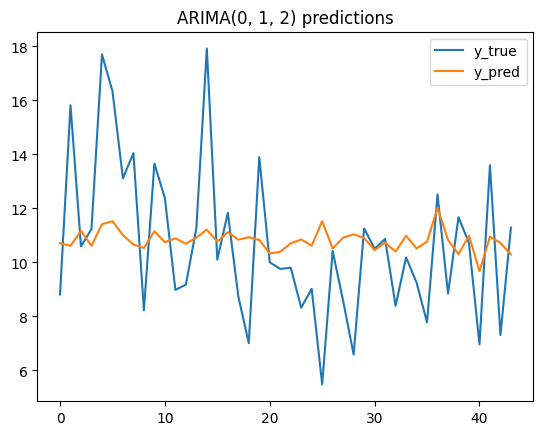

In [115]:
n = len(ts_admin_test)
plt.plot(range(n), ts_admin_test.emission_ges, label='y_true')
plt.plot(range(n), ges_pred, label='y_pred')
plt.legend()
plt.title('ARIMA(0, 1, 2) predictions')
plt.show()

In [117]:
rmse = mean_squared_error(y_true=ts_admin_test.emission_ges, y_pred=ges_pred)
print(f'RMSE: {rmse}')

RMSE: 7.411588650654485


**Comparing models**

c:\Users\mouad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


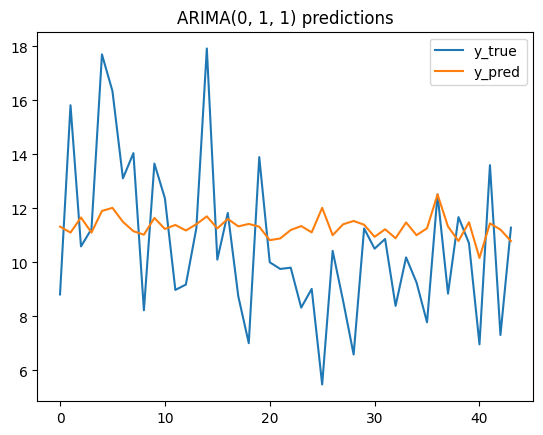

RMSE: 7.798039322810951


c:\Users\mouad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


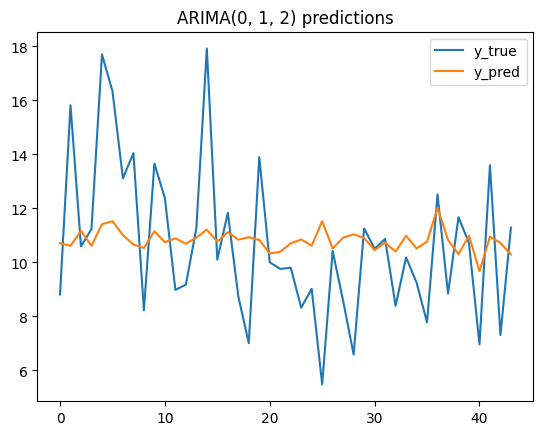

RMSE: 7.411588650654485


c:\Users\mouad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


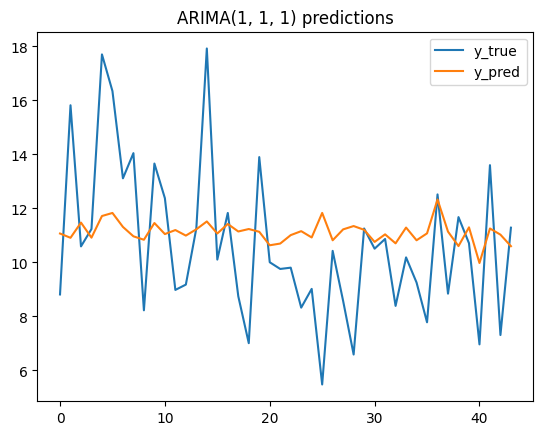

RMSE: 7.591182059156404


c:\Users\mouad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


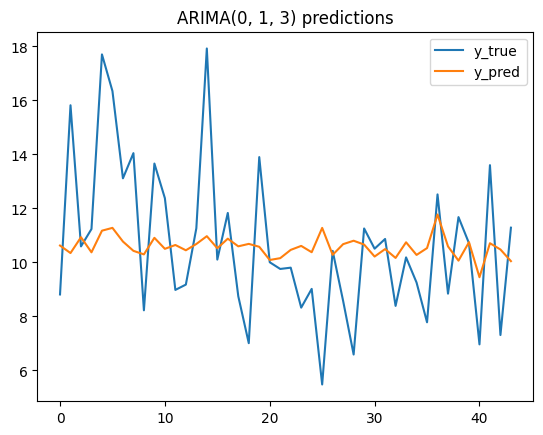

RMSE: 7.4241768863279045


In [126]:
def fit_and_plot(ts, order):
    ts_train, ts_test = split(ts)
    model = ARIMA(endog=ts_train.emission_ges, exog=ts_train.drop(columns='emission_ges'), order=order)
    model_fit = model.fit()
    ges_pred = model_fit.forecast(steps=len(ts_test), exog=ts_test.drop(columns='emission_ges'))
    
    n = len(ts_test)
    plt.plot(range(n), ts_test.emission_ges, label='y_true')
    plt.plot(range(n), ges_pred, label='y_pred')
    plt.legend()
    plt.title(f'ARIMA{order} predictions')
    plt.show()
    
    rmse = mean_squared_error(y_true=ts_test.emission_ges, y_pred=ges_pred)
    print(f'RMSE: {rmse}')

orders = [(0, 1, 1), (0, 1, 2), (1, 1, 1), (0, 1, 3)]

for order in orders:
    fit_and_plot(ts_admin, order)

**Using auto-arima**

In [ ]:
model = auto_arima(y=ts_admin_train.emission_ges, X=ts_admin_train.drop(columns='emission_ges'), suppress_warnings=True, trace=True)  # Result: ARIMA(1, 1, 5)(0, 0, 0)[0]
model.fit(ts_admin_train.emission_ges, ts_admin_train.drop(columns='emission_ges'))

In [132]:
forecast = model.predict(n_periods=len(ts_admin_test), X=ts_admin_test.drop(columns='emission_ges'))
ts_admin_test['forecast'] = forecast

c:\Users\mouad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


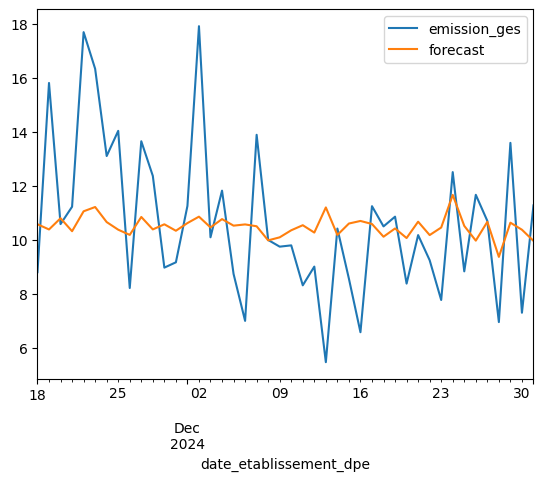

In [133]:
ts_admin_test[['emission_ges', 'forecast']].plot()
plt.show()

**Final result**

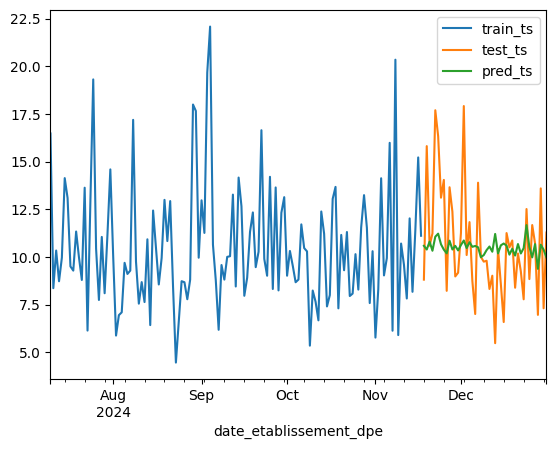

In [140]:
ts_admin_train.emission_ges.iloc[4200:].plot(label='train_ts')
ts_admin_test.emission_ges.plot(label='test_ts')
ts_admin_test['forecast'].plot(label='pred_ts')
plt.legend()
plt.show()